## Part 1A: Creating the classifier - UNet-ResNet 

### Library Import

In [1]:
import os
import json
import tensorflow as tf
import albumentations as albu
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Configuring to run session on GPU

In [ ]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.keras.backend.set_session(tf.Session(config=config));

### Data loading and formatting

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.shape

(22184, 2)

In [4]:
train_df = df[0:15000]
test_df = df[15000:22184]
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['MaskPresent'] = ~ train_df['EncodedPixels'].isna()

C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [5]:
mask_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_df.sort_values('MaskPresent', ascending=False, inplace=True)
print(mask_df.shape)
mask_df.head()


(3750, 2)


,ImageId,MaskPresent
2530,734305a.jpg,4.0
3204,9219fe4.jpg,4.0
3556,a26c013.jpg,4.0
2828,80c5371.jpg,4.0
1675,4d7ab3d.jpg,4.0


In [6]:
test_df['ImageId'] = test_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(test_df['ImageId'].unique(), columns=['ImageId'])

C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Defining Utility Functions

#### Resize function <br>     Reshape a numpy array, which is input_shape=(height, width), as opposed to input_shape=(width, height) for cv2

In [7]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))

#### Mask conversion <br>  1 - mask, 0 - background Returns run length as string formated <br><br> Reference:  https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [8]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [9]:
def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

In [10]:
def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

In [11]:
def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

#### Optimizer

RAdam optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)

In [12]:
#RAdam
class RAdam(keras.optimizers.Optimizer):
    

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                self.min_lr + (lr - self.min_lr) * (1.0 - K.minimum(t, self.total_steps) / self.total_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

#### Loss functions

In [13]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Data Generator

#### Reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [14]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

### Deep Learning

#### Model Architecture

In [15]:
def vanilla_unet(input_shape):
   
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

#### Reference: https://github.com/qubvel/segmentation_models

In [16]:
#Training
BATCH_SIZE = 2

train_idx, val_idx = train_test_split(
    mask_df.index, random_state=2019, test_size=0.2
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4
)

model = sm.Unet(
    'resnet34', 
    classes=4,
    input_shape=(320, 480, 3),
    activation='sigmoid'
)
model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 320, 480, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 486, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 160, 240, 64) 9408        zero_padding2d_1[0][0]         

In [17]:
val_generator = DataGenerator(
    val_idx, 
    df=mask_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(320, 480),
    augment=False,
    n_channels=3,
    n_classes=4
)

In [ ]:
#Creating checkpoint for saving weights
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=10
)


In [18]:
import keras.losses
keras.losses.custom_loss = bce_dice_loss
model.load_weights(os.path.join('model.h5'))

### Testing the model

In [20]:
test_df_1 = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(320, 480),
        n_channels=3,
        base_path='train_images',
        target_df=test_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    )

    for j, b in enumerate(batch_idx):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = test_df[test_df['ImageId'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))

        image_df['EncodedPixels'] = pred_rles
        test_df_1.append(image_df)


296/296 [==============================] - 308s 1s/step


In [21]:
test_df_1 = pd.concat(test_df_1)

In [23]:
test_df_1 = test_df_1.replace(r'^\s*$', np.nan, regex=True)

In [24]:
test_df

,Image_Label,EncodedPixels,ImageId
15000,ab92630.jpg_Fish,1495721 486 1497121 486 1498521 486 1499921 48...,ab92630.jpg
15001,ab92630.jpg_Flower,27216 784 28616 784 30016 784 31416 784 32816 ...,ab92630.jpg
15002,ab92630.jpg_Gravel,NaN,ab92630.jpg
15003,ab92630.jpg_Sugar,1 754 1401 754 2801 754 4201 754 5601 754 7001...,ab92630.jpg
15004,ab98b1b.jpg_Fish,298692 503 300092 503 301492 503 302892 503 30...,ab98b1b.jpg
...,...,...,...
22179,ffd6680.jpg_Sugar,NaN,ffd6680.jpg
22180,ffea4f4.jpg_Fish,NaN,ffea4f4.jpg
22181,ffea4f4.jpg_Flower,1194860 675 1196260 675 1197660 675 1199060 67...,ffea4f4.jpg
22182,ffea4f4.jpg_Gravel,NaN,ffea4f4.jpg


### Evaluating the model

In [25]:
test_df = test_df[~test_df['EncodedPixels'].isnull()]
test_df['Image'] = test_df['Image_Label'].map(lambda x: x.split('_')[0])
test_df['Class'] = test_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = test_df['Class'].unique()
test_df = test_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    test_df[class_name] = test_df['Class'].map(lambda x: 1 if class_name in x else 0)

C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
test_df_1 = test_df_1[~test_df_1['EncodedPixels'].isnull()]
test_df_1['Image'] = test_df_1['Image_Label'].map(lambda x: x.split('_')[0])
test_df_1['Class'] = test_df_1['Image_Label'].map(lambda x: x.split('_')[1])
classes = test_df_1['Class'].unique()
test_df_1 = test_df_1.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    test_df_1[class_name] = test_df_1['Class'].map(lambda x: 1 if class_name in x else 0)

In [27]:
test_df = test_df[test_df.Image != 'bb75314.jpg']
test_df = test_df[test_df.Image != 'f56bfa6.jpg']
test_df = test_df[test_df.Image != 'f0188ae.jpg']

#### Classification report

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 


print("Classification accuracy for class Fish: {:.4%}".format(accuracy_score(test_df_1['Fish'], test_df['Fish'])))
print('Classification Report for class Fish : ')
print(classification_report(test_df_1['Fish'], test_df['Fish']))

print("Classification accuracy for class Flower: {:.4%}".format(accuracy_score(test_df_1['Flower'], test_df['Flower'])))
print('Classification Report for class Flower : ')
print(classification_report(test_df_1['Flower'], test_df['Flower']))

print("Classification accuracy for class Gravel: {:.4%}".format(accuracy_score(test_df_1['Gravel'], test_df['Gravel'])))
print('Classification Report for class Gravel : ')
print(classification_report(test_df_1['Gravel'], test_df['Gravel']))

print("Classification accuracy for class Sugar: {:.4%}".format(accuracy_score(test_df_1['Sugar'], test_df['Sugar'])))
print('Classification Report for class Sugar : ')
print(classification_report(test_df_1['Sugar'], test_df['Sugar']))

Classification accuracy for class Fish: 63.8595%
Classification Report for class Fish : 
              precision    recall  f1-score   support

           0       0.37      0.81      0.51       415
           1       0.91      0.59      0.71      1378

    accuracy                           0.64      1793
   macro avg       0.64      0.70      0.61      1793
weighted avg       0.79      0.64      0.67      1793

Classification accuracy for class Flower: 82.2644%
Classification Report for class Flower : 
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1194
           1       0.69      0.87      0.77       599

    accuracy                           0.82      1793
   macro avg       0.80      0.83      0.81      1793
weighted avg       0.84      0.82      0.83      1793

Classification accuracy for class Gravel: 64.6960%
Classification Report for class Gravel : 
              precision    recall  f1-score   support

           0    

#### Plotting Precision-Recall Curve

#### ROC and PR Curve for class 'Fish'

In [91]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, f1_score, recall_score, precision_score

fpr_fish, tpr_fish, thresholds_fish = metrics.roc_curve(test_df['Fish'],test_df_1['Fish'])
auc_fish = metrics.auc(fpr_fish, tpr_fish)
recall_fish = recall_score(test_df['Fish'],test_df_1['Fish'])
precision_fish = precision_score(test_df['Fish'],test_df_1['Fish'])
f1_fish = f1_score(test_df['Fish'],test_df_1['Fish'])

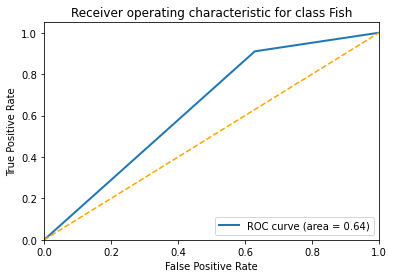

In [92]:
%matplotlib inline
plt.figure()
plt.plot(fpr_fish,tpr_fish, lw=2,label='ROC curve (area = %0.2f)' % auc_fish)
plt.plot([0, 1], [0, 1], color='orange',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver operating characteristic for class Fish')
plt.legend(loc="lower right")
plt.show()

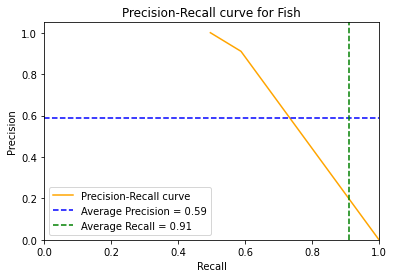

In [93]:
plt.figure()
pr, rc, th = precision_recall_curve(test_df['Fish'],test_df_1['Fish'])
plt.plot(pr, rc, label='Precision-Recall curve', color='orange')
plt.axhline(y=precision_fish, color='blue', linestyle='--',label='Average Precision = %0.2f'%precision_fish)
plt.axvline(x=recall_fish, linestyle='--', color='green',label='Average Recall = %0.2f'%recall_fish)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Fish')
plt.legend(loc="lower left")
plt.show()

#### PR and ROC curve for class 'Flower'

In [94]:
fpr_Flower, tpr_Flower, thresholds_Flower = metrics.roc_curve(test_df['Flower'],test_df_1['Flower'])
auc_Flower = metrics.auc(fpr_Flower, tpr_Flower)
recall_Flower = recall_score(test_df['Flower'],test_df_1['Flower'])
precision_Flower = precision_score(test_df['Flower'],test_df_1['Flower'])
f1_Flower = f1_score(test_df['Flower'],test_df_1['Flower'])

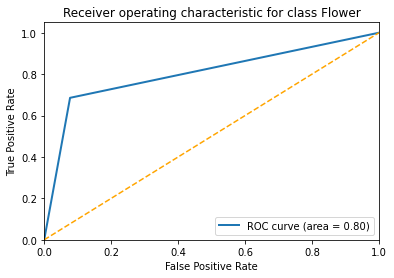

In [95]:
plt.figure()
plt.plot(fpr_Flower,tpr_Flower, lw=2,label='ROC curve (area = %0.2f)' % auc_Flower)
plt.plot([0, 1], [0, 1], color='orange',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver operating characteristic for class Flower')
plt.legend(loc="lower right")
plt.show()

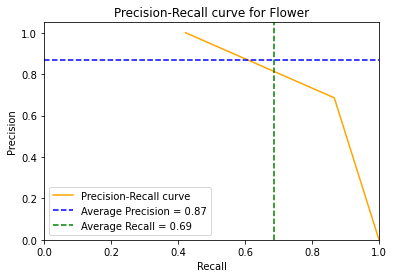

In [84]:
plt.figure()
pr, rc, th = precision_recall_curve(test_df['Flower'],test_df_1['Flower'])
plt.plot(pr, rc, label='Precision-Recall curve', color='orange')
plt.axhline(y=precision_Flower, color='blue', linestyle='--',label='Average Precision = %0.2f'%precision_Flower)
plt.axvline(x=recall_Flower, linestyle='--', color='green',label='Average Recall = %0.2f'%recall_Flower)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Flower')
plt.legend(loc="lower left")
plt.show()

#### PR and ROC curve for class 'Gravel'

In [96]:
fpr_Gravel, tpr_Gravel, thresholds_Gravel = metrics.roc_curve(test_df['Gravel'],test_df_1['Gravel'])
auc_Gravel = metrics.auc(fpr_Gravel, tpr_Gravel)
recall_Gravel = recall_score(test_df['Gravel'],test_df_1['Gravel'])
precision_Gravel = precision_score(test_df['Gravel'],test_df_1['Gravel'])
f1_Gravel = f1_score(test_df['Gravel'],test_df_1['Gravel'])

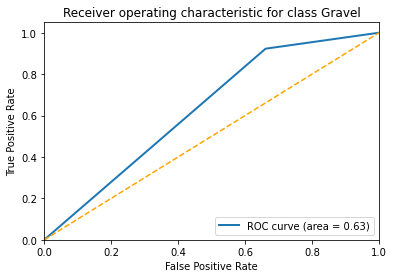

In [97]:
plt.figure()
plt.plot(fpr_Gravel,tpr_Gravel, lw=2,label='ROC curve (area = %0.2f)' % auc_Gravel)
plt.plot([0, 1], [0, 1], color='orange',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver operating characteristic for class Gravel')
plt.legend(loc="lower right")
plt.show()

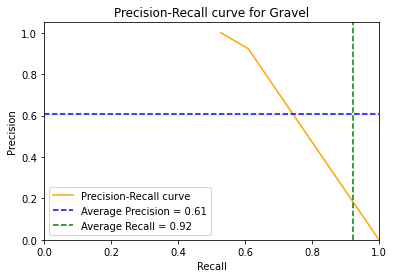

In [98]:
plt.figure()
pr, rc, th = precision_recall_curve(test_df['Gravel'],test_df_1['Gravel'])
plt.plot(pr, rc, label='Precision-Recall curve', color='orange')
plt.axhline(y=precision_Gravel, color='blue', linestyle='--',label='Average Precision = %0.2f'%precision_Gravel)
plt.axvline(x=recall_Gravel, linestyle='--', color='green',label='Average Recall = %0.2f'%recall_Gravel)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Gravel')
plt.legend(loc="lower left")
plt.show()

#### PR and ROC curve for class 'Sugar'

In [99]:
fpr_Sugar, tpr_Sugar, thresholds_Sugar = metrics.roc_curve(test_df['Sugar'],test_df_1['Sugar'])
auc_Sugar = metrics.auc(fpr_Sugar, tpr_Sugar)
recall_Sugar = recall_score(test_df['Sugar'],test_df_1['Sugar'])
precision_Sugar = precision_score(test_df['Sugar'],test_df_1['Sugar'])
f1_Sugar = f1_score(test_df['Sugar'],test_df_1['Sugar'])

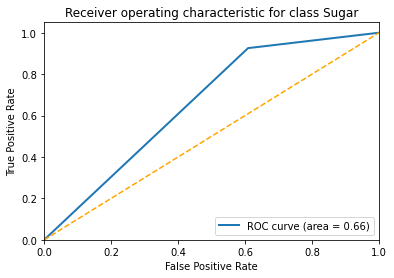

In [100]:
plt.figure()
plt.plot(fpr_Sugar,tpr_Sugar, lw=2,label='ROC curve (area = %0.2f)' % auc_Sugar)
plt.plot([0, 1], [0, 1], color='orange',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver operating characteristic for class Sugar')
plt.legend(loc="lower right")
plt.show()

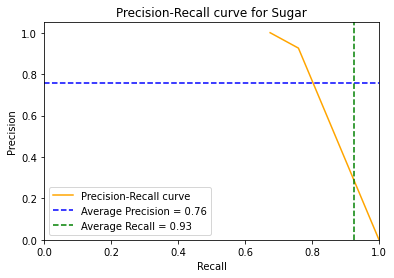

In [101]:
plt.figure()
pr, rc, th = precision_recall_curve(test_df['Sugar'],test_df_1['Sugar'])
plt.plot(pr, rc, label='Precision-Recall curve', color='orange')
plt.axhline(y=precision_Sugar, color='blue', linestyle='--',label='Average Precision = %0.2f'%precision_Sugar)
plt.axvline(x=recall_Sugar, linestyle='--', color='green',label='Average Recall = %0.2f'%recall_Sugar)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Sugar')
plt.legend(loc="lower left")
plt.show()